In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import tqdm
import utils as utils
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp
import fit_Plain_GP as plaingp

#### Predict on SSP585

In [3]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370']}, 'response_var': 'pr'}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}, 'response_var': 'pr'}
test_data = plaingp.make_data(test_cfg)

'''
gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp585/PlainGP/state_dict.pt')
gpmodel.load_state_dict(state_dict)
'''

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('/home/skala/ForceSMIP/output/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)


<All keys matched successfully>

In [4]:
test_scenarios = test_data.scenarios
'''
for s in test_scenarios.scenarios.values():
    s.name = s.name + '-test'
'''


test_times = test_scenarios.timesteps
test_tas = test_scenarios.response_var
test_tas_fair = fairgpmodel._compute_mean(test_scenarios)



'''
X_test = torch.cat([test_scenarios.cum_emissions[:, 0, None],
                    test_scenarios.emissions[:, 1:]], dim=-1)
X_test = (X_test - gpmodel.mu) / gpmodel.sigma

gpmodel = gpmodel.eval()
fairgpmodel = fairgpmodel.eval()

with torch.no_grad():
    gp_test_prior = gpmodel.forward(X_test)
    mean = gpmodel.sigma_targets * gp_test_prior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * gp_test_prior.covariance_matrix
    gp_test_prior = gp_test_prior.__class__(mean, covar)
    
    noisy_gp_test_prior = gpmodel.likelihood(gpmodel.forward(X_test))
    mean = gpmodel.sigma_targets * noisy_gp_test_prior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_prior.covariance_matrix
    noisy_gp_test_prior = noisy_gp_test_prior.__class__(mean, covar)
    
    gp_test_posterior = gpmodel(X_test)
    mean = gpmodel.sigma_targets * gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * gp_test_posterior.covariance_matrix
    gp_test_posterior = gp_test_posterior.__class__(mean, gpytorch.add_jitter(covar))
    
    noisy_gp_test_posterior = gpmodel.likelihood(gpmodel(X_test))
    mean = gpmodel.sigma_targets * noisy_gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_posterior.covariance_matrix
    noisy_gp_test_posterior = noisy_gp_test_posterior.__class__(mean, covar)
'''
fairgpmodel = fairgpmodel.eval()

with torch.no_grad():
    fairgp_test_prior = fairgpmodel.forward(test_scenarios)
    noisy_fairgp_test_prior = fairgpmodel.likelihood(fairgp_test_prior)
    
    fairgp_test_posterior = fairgpmodel(test_scenarios)
    noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)

/home/skala/miniconda3/envs/mypython38/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/skala/miniconda3/envs/mypython38/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


In [5]:
test_scenarios

ScenarioDataset(
  (scenarios): ModuleDict(
    (ssp585): Scenario(ssp585)
  )
  (hist_scenario): Scenario(historical)
)

In [6]:
fairgpmodel.train_scenarios + test_scenarios

ScenarioDataset(
  (scenarios): ModuleDict(
    (historical): Scenario(historical)
    (ssp126): Scenario(ssp126)
    (ssp245): Scenario(ssp245)
    (ssp370): Scenario(ssp370)
    (ssp585): Scenario(ssp585)
  )
  (hist_scenario): Scenario(historical)
)

In [7]:
gp_prior_mean = gp_test_prior.mean
gp_prior_lb, gp_prior_ub = gp_test_prior.confidence_region()
gp_prior_lb = gp_prior_lb.detach()
gp_prior_ub = gp_prior_ub.detach()

noisy_gp_prior_lb, noisy_gp_prior_ub = noisy_gp_test_prior.confidence_region()
noisy_gp_prior_lb = noisy_gp_prior_lb.detach()
noisy_gp_prior_ub = noisy_gp_prior_ub.detach()

gp_posterior_mean = noisy_gp_test_posterior.mean
gp_posterior_lb, gp_posterior_ub = gp_test_posterior.confidence_region()
gp_posterior_lb = gp_posterior_lb.detach()
gp_posterior_ub = gp_posterior_ub.detach()

noisy_gp_posterior_lb, noisy_gp_posterior_ub = noisy_gp_test_posterior.confidence_region()
noisy_gp_posterior_lb = noisy_gp_posterior_lb.detach()
noisy_gp_posterior_ub = noisy_gp_posterior_ub.detach()

NameError: name 'gp_test_prior' is not defined

In [9]:
test_tas_fair

tensor([0.0581, 0.0847, 0.1203, 0.1609, 0.2037, 0.2470, 0.2895, 0.3309, 0.3711,
        0.4101])

In [11]:
fairgp_test_posterior.mean

tensor([])

In [8]:
fairgp_prior_mean = fairgp_test_prior.mean + test_tas_fair
fairgp_prior_lb, fairgp_prior_ub = fairgp_test_prior.confidence_region()
fairgp_prior_lb = fairgp_prior_lb.detach() + test_tas_fair
fairgp_prior_ub = fairgp_prior_ub.detach() + test_tas_fair

noisy_fairgp_prior_lb, noisy_fairgp_prior_ub = noisy_fairgp_test_prior.confidence_region()
noisy_fairgp_prior_lb = noisy_fairgp_prior_lb.detach() + test_tas_fair
noisy_fairgp_prior_ub = noisy_fairgp_prior_ub.detach() + test_tas_fair

fairgp_posterior_mean = fairgp_test_posterior.mean + test_tas_fair
fairgp_posterior_lb, fairgp_posterior_ub = fairgp_test_posterior.confidence_region()
fairgp_posterior_lb = fairgp_posterior_lb.detach() + test_tas_fair
fairgp_posterior_ub = fairgp_posterior_ub.detach() + test_tas_fair

noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub = noisy_fairgp_test_posterior.confidence_region()
noisy_fairgp_posterior_lb = noisy_fairgp_posterior_lb.detach() + test_tas_fair
noisy_fairgp_posterior_ub = noisy_fairgp_posterior_ub.detach() + test_tas_fair

In [11]:
#fairgp_prior_mean

/tmp/ipykernel_1750777/418513696.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[4].set_alpha(0.4)


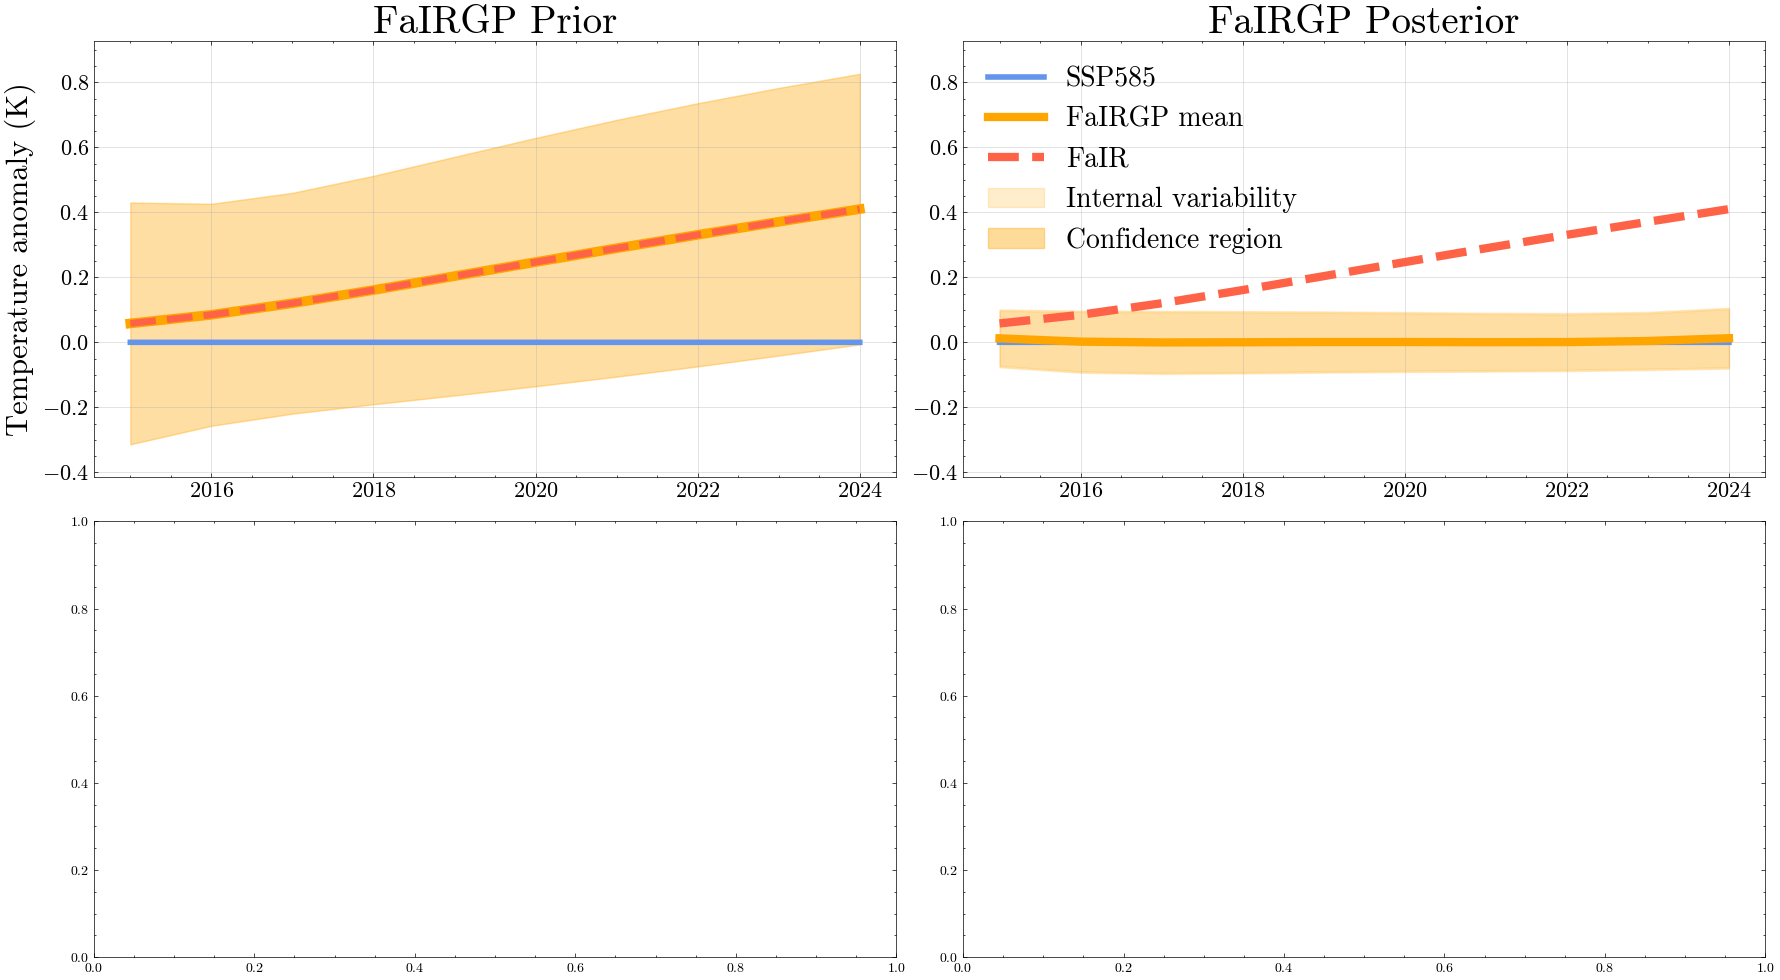

In [15]:
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ymax = max(noisy_fairgp_prior_ub.max(), noisy_fairgp_posterior_ub.max()
           #noisy_gp_posterior_ub.max()
           ) + 0.1
ymin = min(noisy_fairgp_prior_lb.min(), noisy_fairgp_posterior_lb.min(),
           #noisy_gp_posterior_lb.min()
           ) - 0.1


ax[0, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP585')
ax[0, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0, 0].plot(test_times, fairgp_prior_mean, color='orange', lw=7, label='Prior mean')
ax[0, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0, 0].fill_between(test_times, fairgp_prior_lb, fairgp_prior_ub, alpha=0.2, color='orange')
ax[0, 0].fill_between(test_times, noisy_fairgp_prior_lb, noisy_fairgp_prior_ub, alpha=0.2, color='orange')
ax[0, 0].tick_params(labelsize=16)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].set_ylim(ymin, ymax)
ax[0, 0].set_title(r'FaIRGP Prior', fontsize=28)


ax[0, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP585')
ax[0, 1].plot(test_times, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[0, 1].fill_between(test_times, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[0, 1].fill_between(test_times, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_ylim(ymin, ymax)
ax[0, 1].set_title(r'FaIRGP Posterior', fontsize=28)


legend = ax[0, 1].legend(loc='upper left', fontsize=20)
legend.legendHandles[4].set_alpha(0.4)


'''
ax[1, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP585')
ax[1, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 0].plot(test_times, gp_prior_mean, color='mediumseagreen', lw=7, label='Prior mean')
ax[1, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[1, 0].fill_between(test_times, gp_prior_lb, gp_prior_ub, alpha=0.2, color='mediumseagreen')
ax[1, 0].fill_between(test_times, noisy_gp_prior_lb, noisy_gp_prior_ub, alpha=0.2, color='mediumseagreen')
ax[1, 0].tick_params(labelsize=16)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_ylim(ymin, ymax)
ax[1, 0].set_title(r'Plain GP Prior', fontsize=28)

ax[1, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP585')
ax[1, 1].plot(test_times, gp_posterior_mean, color='mediumseagreen', lw=6, label='GP mean')
ax[1, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 1].fill_between(test_times, gp_posterior_lb, gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                   label='Observation noise')
ax[1, 1].fill_between(test_times, noisy_gp_posterior_lb, noisy_gp_posterior_ub, alpha=0.2, color='mediumseagreen',
               label='Confidence region')
ax[1, 1].tick_params(labelsize=16)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_ylim(ymin, ymax)
ax[1, 1].set_title(r'Plain GP Posterior', fontsize=28)

legend = ax[1, 1].legend(loc='upper left', fontsize=20)
legend.legendHandles[4].set_alpha(0.4)

'''

plt.tight_layout()
# plt.savefig('SSP585-prediction.png', dpi=300)
plt.show()

#### Predict on SSP245

In [ ]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = plaingp.make_data(test_cfg)

gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp245/PlainGP/state_dict.pt')
gpmodel.load_state_dict(state_dict)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/experiments/outputs/ssps/GFaIR/fold_ssp245/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test_scenarios = test_data.scenarios
test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas
test_tas_fair = fairgpmodel._compute_mean(test_scenarios)
X_test = torch.cat([test_scenarios.cum_emissions[:, 0, None],
                    test_scenarios.emissions[:, 1:]], dim=-1)
X_test = (X_test - gpmodel.mu) / gpmodel.sigma

gpmodel = gpmodel.eval()
fairgpmodel = fairgpmodel.eval()

with torch.no_grad():
    gp_test_prior = gpmodel.forward(X_test)
    mean = gpmodel.sigma_targets * gp_test_prior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * gp_test_prior.covariance_matrix
    gp_test_prior = gp_test_prior.__class__(mean, gpytorch.add_jitter(covar))
    
    noisy_gp_test_prior = gpmodel.likelihood(gpmodel.forward(X_test))
    mean = gpmodel.sigma_targets * noisy_gp_test_prior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_prior.covariance_matrix
    noisy_gp_test_prior = noisy_gp_test_prior.__class__(mean, covar)
    
    gp_test_posterior = gpmodel(X_test)
    mean = gpmodel.sigma_targets * gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * gp_test_posterior.covariance_matrix
    gp_test_posterior = gp_test_posterior.__class__(mean, gpytorch.add_jitter(covar))
    
    noisy_gp_test_posterior = gpmodel.likelihood(gpmodel(X_test))
    mean = gpmodel.sigma_targets * noisy_gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_posterior.covariance_matrix
    noisy_gp_test_posterior = noisy_gp_test_posterior.__class__(mean, covar)
    
with torch.no_grad():
    fairgp_test_prior = fairgpmodel.forward(test_scenarios)
    noisy_fairgp_test_prior = fairgpmodel.likelihood(fairgp_test_prior)
    
    fairgp_test_posterior = fairgpmodel(test_scenarios)
    noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)

/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


In [ ]:
gp_prior_mean = gp_test_prior.mean
gp_prior_lb, gp_prior_ub = gp_test_prior.confidence_region()
gp_prior_lb = gp_prior_lb.detach()
gp_prior_ub = gp_prior_ub.detach()

noisy_gp_prior_lb, noisy_gp_prior_ub = noisy_gp_test_prior.confidence_region()
noisy_gp_prior_lb = noisy_gp_prior_lb.detach()
noisy_gp_prior_ub = noisy_gp_prior_ub.detach()

gp_posterior_mean = noisy_gp_test_posterior.mean
gp_posterior_lb, gp_posterior_ub = gp_test_posterior.confidence_region()
gp_posterior_lb = gp_posterior_lb.detach()
gp_posterior_ub = gp_posterior_ub.detach()

noisy_gp_posterior_lb, noisy_gp_posterior_ub = noisy_gp_test_posterior.confidence_region()
noisy_gp_posterior_lb = noisy_gp_posterior_lb.detach()
noisy_gp_posterior_ub = noisy_gp_posterior_ub.detach()

In [ ]:
fairgp_prior_mean = fairgp_test_prior.mean + test_tas_fair
fairgp_prior_lb, fairgp_prior_ub = fairgp_test_prior.confidence_region()
fairgp_prior_lb = fairgp_prior_lb.detach() + test_tas_fair
fairgp_prior_ub = fairgp_prior_ub.detach() + test_tas_fair

noisy_fairgp_prior_lb, noisy_fairgp_prior_ub = noisy_fairgp_test_prior.confidence_region()
noisy_fairgp_prior_lb = noisy_fairgp_prior_lb.detach() + test_tas_fair
noisy_fairgp_prior_ub = noisy_fairgp_prior_ub.detach() + test_tas_fair

fairgp_posterior_mean = fairgp_test_posterior.mean + test_tas_fair
fairgp_posterior_lb, fairgp_posterior_ub = fairgp_test_posterior.confidence_region()
fairgp_posterior_lb = fairgp_posterior_lb.detach() + test_tas_fair
fairgp_posterior_ub = fairgp_posterior_ub.detach() + test_tas_fair

noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub = noisy_fairgp_test_posterior.confidence_region()
noisy_fairgp_posterior_lb = noisy_fairgp_posterior_lb.detach() + test_tas_fair
noisy_fairgp_posterior_ub = noisy_fairgp_posterior_ub.detach() + test_tas_fair

/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


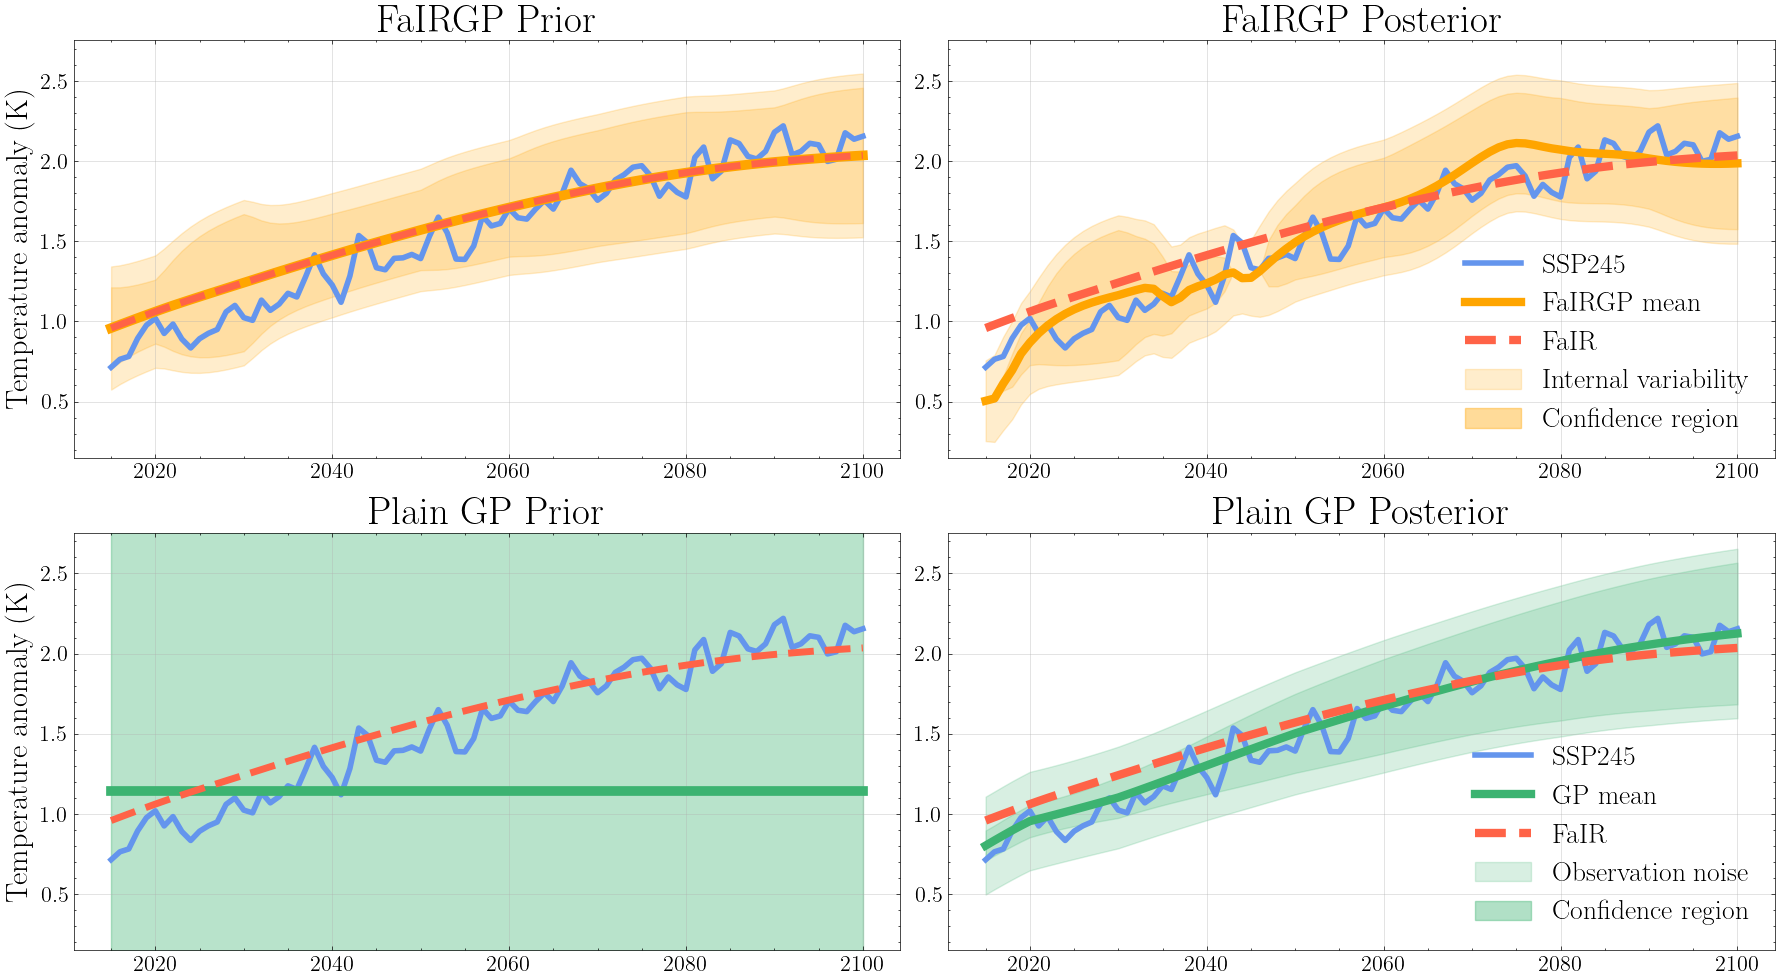

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ymax = max(noisy_fairgp_prior_ub.max(), noisy_fairgp_posterior_ub.max(),
            noisy_gp_posterior_ub.max()) + 0.1
ymin = min(noisy_fairgp_prior_lb.min(), noisy_fairgp_posterior_lb.min(),
            noisy_gp_posterior_lb.min()) - 0.1


ax[0, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP245')
ax[0, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0, 0].plot(test_times, fairgp_prior_mean, color='orange', lw=7, label='Prior mean')
ax[0, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0, 0].fill_between(test_times, fairgp_prior_lb, fairgp_prior_ub, alpha=0.2, color='orange')
ax[0, 0].fill_between(test_times, noisy_fairgp_prior_lb, noisy_fairgp_prior_ub, alpha=0.2, color='orange')
ax[0, 0].tick_params(labelsize=16)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].set_ylim(ymin, ymax)
ax[0, 0].set_title(r'FaIRGP Prior', fontsize=28)

ax[0, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP245')
ax[0, 1].plot(test_times, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[0, 1].fill_between(test_times, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[0, 1].fill_between(test_times, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_ylim(ymin, ymax)
ax[0, 1].set_title(r'FaIRGP Posterior', fontsize=28)

legend = ax[0, 1].legend(loc='lower right', fontsize=20)
legend.legendHandles[4].set_alpha(0.4)



ax[1, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP245')
ax[1, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 0].plot(test_times, gp_prior_mean, color='mediumseagreen', lw=7, label='Prior mean')
ax[1, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[1, 0].fill_between(test_times, gp_prior_lb, gp_prior_ub, alpha=0.2, color='mediumseagreen')
ax[1, 0].fill_between(test_times, noisy_gp_prior_lb, noisy_gp_prior_ub, alpha=0.2, color='mediumseagreen')
ax[1, 0].tick_params(labelsize=16)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_ylim(ymin, ymax)
ax[1, 0].set_title(r'Plain GP Prior', fontsize=28)

ax[1, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP245')
ax[1, 1].plot(test_times, gp_posterior_mean, color='mediumseagreen', lw=6, label='GP mean')
ax[1, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 1].fill_between(test_times, gp_posterior_lb, gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                   label='Observation noise')
ax[1, 1].fill_between(test_times, noisy_gp_posterior_lb, noisy_gp_posterior_ub, alpha=0.2, color='mediumseagreen',
               label='Confidence region')
ax[1, 1].tick_params(labelsize=16)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_ylim(ymin, ymax)
ax[1, 1].set_title(r'Plain GP Posterior', fontsize=28)

legend = ax[1, 1].legend(loc='lower right', fontsize=20)
legend.legendHandles[4].set_alpha(0.4)

plt.tight_layout()
# plt.savefig('SSP245-prediction.png', dpi=300)
plt.show()

#### Predict on SSP126

In [ ]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = plaingp.make_data(test_cfg)

gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/experiments/outputs/ssps/plain-GP/fold_ssp126/state_dict.pt')
gpmodel.load_state_dict(state_dict)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/experiments/outputs/ssps/GFaIR/fold_ssp126/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test_scenarios = test_data.scenarios
test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas
test_tas_fair = fairgpmodel._compute_mean(test_scenarios)
X_test = torch.cat([test_scenarios.cum_emissions[:, 0, None],
                    test_scenarios.emissions[:, 1:]], dim=-1)
X_test = (X_test - gpmodel.mu) / gpmodel.sigma

gpmodel = gpmodel.eval()
fairgpmodel = fairgpmodel.eval()

with torch.no_grad():
    gp_test_prior = gpmodel.forward(X_test)
    mean = gpmodel.sigma_targets * gp_test_prior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * gp_test_prior.covariance_matrix
    gp_test_prior = gp_test_prior.__class__(mean, gpytorch.add_jitter(covar))
    
    noisy_gp_test_prior = gpmodel.likelihood(gpmodel.forward(X_test))
    mean = gpmodel.sigma_targets * noisy_gp_test_prior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_prior.covariance_matrix
    noisy_gp_test_prior = noisy_gp_test_prior.__class__(mean, covar)
    
    gp_test_posterior = gpmodel(X_test)
    mean = gpmodel.sigma_targets * gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * gp_test_posterior.covariance_matrix
    gp_test_posterior = gp_test_posterior.__class__(mean, gpytorch.add_jitter(covar))
    
    noisy_gp_test_posterior = gpmodel.likelihood(gpmodel(X_test))
    mean = gpmodel.sigma_targets * noisy_gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_posterior.covariance_matrix
    noisy_gp_test_posterior = noisy_gp_test_posterior.__class__(mean, covar)
    
with torch.no_grad():
    fairgp_test_prior = fairgpmodel.forward(test_scenarios)
    noisy_fairgp_test_prior = fairgpmodel.likelihood(fairgp_test_prior)
    
    fairgp_test_posterior = fairgpmodel(test_scenarios)
    noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)

/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


In [ ]:
gp_prior_mean = gp_test_prior.mean
gp_prior_lb, gp_prior_ub = gp_test_prior.confidence_region()
gp_prior_lb = gp_prior_lb.detach()
gp_prior_ub = gp_prior_ub.detach()

noisy_gp_prior_lb, noisy_gp_prior_ub = noisy_gp_test_prior.confidence_region()
noisy_gp_prior_lb = noisy_gp_prior_lb.detach()
noisy_gp_prior_ub = noisy_gp_prior_ub.detach()

gp_posterior_mean = noisy_gp_test_posterior.mean
gp_posterior_lb, gp_posterior_ub = gp_test_posterior.confidence_region()
gp_posterior_lb = gp_posterior_lb.detach()
gp_posterior_ub = gp_posterior_ub.detach()

noisy_gp_posterior_lb, noisy_gp_posterior_ub = noisy_gp_test_posterior.confidence_region()
noisy_gp_posterior_lb = noisy_gp_posterior_lb.detach()
noisy_gp_posterior_ub = noisy_gp_posterior_ub.detach()

In [ ]:
fairgp_prior_mean = fairgp_test_prior.mean + test_tas_fair
fairgp_prior_lb, fairgp_prior_ub = fairgp_test_prior.confidence_region()
fairgp_prior_lb = fairgp_prior_lb.detach() + test_tas_fair
fairgp_prior_ub = fairgp_prior_ub.detach() + test_tas_fair

noisy_fairgp_prior_lb, noisy_fairgp_prior_ub = noisy_fairgp_test_prior.confidence_region()
noisy_fairgp_prior_lb = noisy_fairgp_prior_lb.detach() + test_tas_fair
noisy_fairgp_prior_ub = noisy_fairgp_prior_ub.detach() + test_tas_fair

fairgp_posterior_mean = fairgp_test_posterior.mean + test_tas_fair
fairgp_posterior_lb, fairgp_posterior_ub = fairgp_test_posterior.confidence_region()
fairgp_posterior_lb = fairgp_posterior_lb.detach() + test_tas_fair
fairgp_posterior_ub = fairgp_posterior_ub.detach() + test_tas_fair

noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub = noisy_fairgp_test_posterior.confidence_region()
noisy_fairgp_posterior_lb = noisy_fairgp_posterior_lb.detach() + test_tas_fair
noisy_fairgp_posterior_ub = noisy_fairgp_posterior_ub.detach() + test_tas_fair

/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


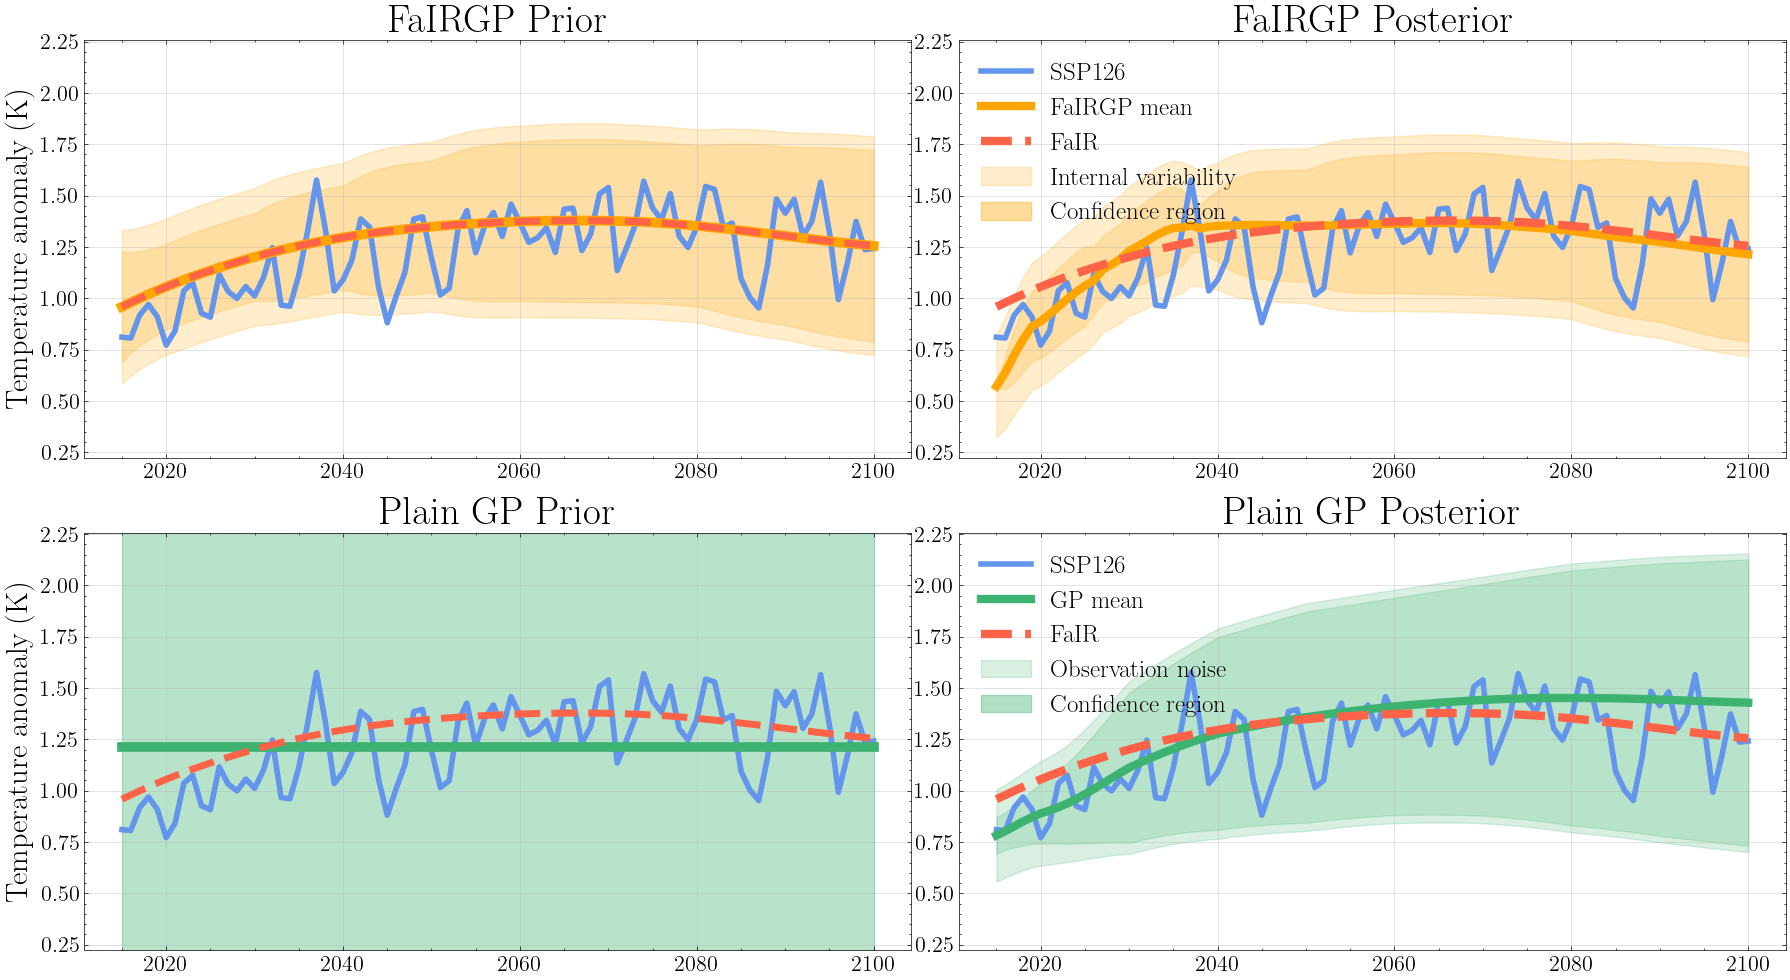

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ymax = max(noisy_fairgp_prior_ub.max(), noisy_fairgp_posterior_ub.max(),
           noisy_gp_posterior_ub.max()) + 0.1
ymin = min(noisy_fairgp_prior_lb.min(), noisy_fairgp_posterior_lb.min(),
           noisy_gp_posterior_lb.min()) - 0.1


ax[0, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[0, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0, 0].plot(test_times, fairgp_prior_mean, color='orange', lw=7, label='Prior mean')
ax[0, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[0, 0].fill_between(test_times, fairgp_prior_lb, fairgp_prior_ub, alpha=0.2, color='orange')
ax[0, 0].fill_between(test_times, noisy_fairgp_prior_lb, noisy_fairgp_prior_ub, alpha=0.2, color='orange')
ax[0, 0].tick_params(labelsize=16)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].set_ylim(ymin, ymax)
ax[0, 0].set_title(r'FaIRGP Prior', fontsize=28)

ax[0, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[0, 1].plot(test_times, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[0, 1].fill_between(test_times, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[0, 1].fill_between(test_times, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_ylim(ymin, ymax)
ax[0, 1].set_title(r'FaIRGP Posterior', fontsize=28)

legend = ax[0, 1].legend(loc='upper left', fontsize=18)
legend.legendHandles[4].set_alpha(0.4)



ax[1, 0].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[1, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 0].plot(test_times, gp_prior_mean, color='mediumseagreen', lw=7, label='Prior mean')
ax[1, 0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=5, label='FaIR')
ax[1, 0].fill_between(test_times, gp_prior_lb, gp_prior_ub, alpha=0.2, color='mediumseagreen')
ax[1, 0].fill_between(test_times, noisy_gp_prior_lb, noisy_gp_prior_ub, alpha=0.2, color='mediumseagreen')
ax[1, 0].tick_params(labelsize=16)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_ylim(ymin, ymax)
ax[1, 0].set_title(r'Plain GP Prior', fontsize=28)

ax[1, 1].plot(test_times, test_tas, lw=4, color='cornflowerblue', label='SSP126')
ax[1, 1].plot(test_times, gp_posterior_mean, color='mediumseagreen', lw=6, label='GP mean')
ax[1, 1].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 1].fill_between(test_times, gp_posterior_lb, gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                   label='Observation noise')
ax[1, 1].fill_between(test_times, noisy_gp_posterior_lb, noisy_gp_posterior_ub, alpha=0.2, color='mediumseagreen',
               label='Confidence region')
ax[1, 1].tick_params(labelsize=16)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_ylim(ymin, ymax)
ax[1, 1].set_title(r'Plain GP Posterior', fontsize=28)

legend = ax[1, 1].legend(loc='upper left', fontsize=18)
legend.legendHandles[4].set_alpha(0.4)

plt.tight_layout()
# plt.savefig('SSP126-prediction.png', dpi=300)
plt.show()